This notebook is a first attempt to create a bad pixel map for ComCam. It uses a simple rejection of pixels whose count numbers are outside n-sigma from the mean pixel value. It is currently set up to work with flat pairs from runs in April 2019, and the final rejected pixels are the ones which are flagged in both flat images.

Importing:

In [1]:
import numpy as np
import lsst.daf.persistence as dafPersist
import lsst.ip.isr.assembleCcdTask as assemble   # force an import of pcaPsfDeterminer.py (which selects ds9) (DM-13432)
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip

%matplotlib inline

Point at the pre-ingested repository:

In [2]:
#dataPath = "/datasets/comCam/repo/rtm5" % This dataset is for rtm5 and makes a good comparison to ComCam
dataPath = "/project/shared/comCam"

butler = dafPersist.Butler(dataPath)
print("Available runs: %s" % (" ".join(butler.queryMetadata('raw', ['run']))))  # available runs


Available runs: -1 10578 10579 10580 10581 10589 10591 10592 10593 10594


Decide which run and which images to use. This run was taken April 18, 2019 with 2-second readout and CCDs at ~-50C. The images are at an exposure time which results in an average of ~10,000 counts in each pixel.

In [3]:
print(butler.queryMetadata('raw',['visit','exptime'],imageType='FLAT',testType='FLAT', run=10594, exptime=18))
ptc_visits=butler.queryMetadata('raw', ['visit'], imageType='FLAT', testType='FLAT', run=10594, exptime=18)
print(len(ptc_visits))

[(201904190333340, 18.0), (201904190333587, 18.0)]
2


In [4]:
# Function to overlay amplifier boxes on the dead pixel graph
def drawAmps(axes):
    x=512
    y=2002
    
    for i in range(3):
        axes.axhline(y=i*y-0.5,c='gray',lw=1)
    
    for i in range(9):
        axes.axvline(x=i*x-0.5,c='gray',lw=1)
        
    for i in range(1,9):
        axes.text((i-0.5)*x,y+30,str(i),color='b',horizontalalignment='center')
        axes.text((i-0.5)*x,30,str(i+8),color='b',horizontalalignment='center')

This cell does everything you need to find the dead pixels of one raft and plot them. It bases rejections off of a basic sigma clipping procedure (currently 3.5 sigma). The plotted points ignore the edge rolloff of the CCD, which is currently set manually, and could use a more standard definition to ignore them.

The orientation of the CCDs and amplifiers needs to be checked - this was the best guess I could come up with for what is correct, but that's certainly not necessarily true.

FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)


Rejected pixels in both: 6.708%
Rejected pixels not including edges: 6.355%
CCD S20: 2.298% high values


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)


Rejected pixels in both: 6.510%
Rejected pixels not including edges: 6.156%
CCD S21: 2.142% high values


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)


Rejected pixels in both: 5.605%
Rejected pixels not including edges: 5.282%
CCD S22: 0.844% high values


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)


Rejected pixels in both: 0.708%
Rejected pixels not including edges: 0.371%
CCD S10: 43.916% high values


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)


Rejected pixels in both: 0.497%
Rejected pixels not including edges: 0.214%
CCD S11: 32.075% high values


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)


Rejected pixels in both: 0.532%
Rejected pixels not including edges: 0.205%
CCD S12: 21.255% high values


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)


Rejected pixels in both: 0.704%
Rejected pixels not including edges: 0.263%
CCD S00: 32.262% high values


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)


Rejected pixels in both: 0.591%
Rejected pixels not including edges: 0.237%
CCD S01: 27.454% high values


FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)
FILTPOS key not found in header (assuming NONE)


Rejected pixels in both: 0.483%
Rejected pixels not including edges: 0.138%
CCD S02: 19.399% high values


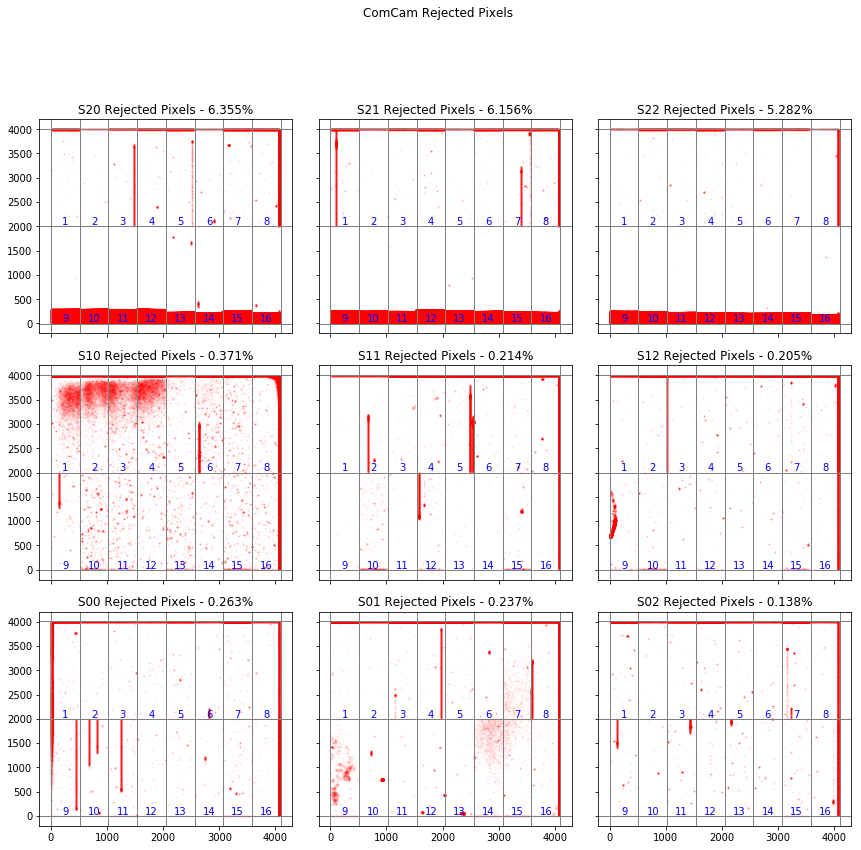

In [6]:
# The CCDs are in this order because I thought they were ordered right to left, bottom to top.
# Might not be true, but this order plots the CCDs in that orientation
CCDs = ['S20', 'S21', 'S22', 'S10', 'S11', 'S12', 'S00', 'S01', 'S02']
fig, axes = plt.subplots(3,3, sharex='all', sharey='all', figsize=(12,12))
axes = np.reshape(axes,9)
fig.suptitle("ComCam Rejected Pixels")
plt.tight_layout()
plt.subplots_adjust(hspace=0.15, top=0.85)

for c in range(9):
    CCD = CCDs[c]
    sig = 3.5 #set sigma value

    # Get flat fields
    dataId1 = dict(visit=ptc_visits[0], detectorName=CCD) # flat1
    dataId2 = dict(visit=ptc_visits[1], detectorName=CCD) # flat2
    flat1 = butler.get('raw', dataId1)
    flat2 = butler.get('raw', dataId2)
    # get() currently throws a "FILTPOS key not found in header (assuming NONE)" error - it's safe

    detector = butler.get('raw', dataId1)

    # Assemble CCD (remove overscan)
    a = assemble.AssembleCcdTask()
    flat1Trim = a.assembleCcd(flat1)
    flat2Trim = a.assembleCcd(flat2)

    # Initialize lists of rejected pixels
    rejx1 = np.array([])
    rejy1 = np.array([])
    rejx2 = np.array([])
    rejy2 = np.array([])

    # Loop over amps
    for i in range(16):
        # Find reject pixels in each amp, store pixel numbers of both images
        amp=detector.getDetector()[i]
        
        values1 = flat1Trim[amp.getBBox()].image.array
        values2 = flat2Trim[amp.getBBox()].image.array
        
        # Store the size of the amplifier
        npxX1 = values1.shape[1]
        npxY1 = values1.shape[0]
        npxX2 = values2.shape[1]
        npxY2 = values2.shape[0]
        
        # Find rejected pixels
        # Everything below here is kind of messy and probably inefficient
        sigclip = SigmaClip(sigma=sig)
        clipped1 = sigclip(values1)
        clipped2 = sigclip(values2)
        mask1 = clipped1.mask
        mask2 = clipped2.mask
        rej1 = np.nonzero(mask1 != 0) # Find everywhere that was rejected
        rej2 = np.nonzero(mask2 != 0)
        ampRej1x = rej1[1]
        ampRej1y = rej1[0]
        ampRej2x = rej2[1]
        ampRej2y = rej2[0]
        
        # Move rejected pixels to the correct amplifier location
        # This if statement exists because of the order the amps are listed in getBBox()
        # (Right across bottom then left across top)
        if i<8:
            ampRej1x = np.add(ampRej1x, i*npxX1)
            ampRej2x = np.add(ampRej2x, i*npxX2)
        else:
            ampRej1y = np.add(ampRej1y, npxY1)
            ampRej1x = np.add(ampRej1x, (15-i)*npxX1)
            ampRej2y = np.add(ampRej2y, npxY2)
            ampRej2x = np.add(ampRej2x, (15-i)*npxX2)
        # I believe this is the correct orientation of each amplifier, but again could be wrong
        
        # Append to master list of rejected pixels in the CCD
        rejx1 = np.append(rejx1,ampRej1x)
        rejy1 = np.append(rejy1,ampRej1y)
        rejx2 = np.append(rejx2,ampRej2x)
        rejy2 = np.append(rejy2,ampRej2y)

    # Find dead pixels in both images
    # This part gets even more sloppy and should probably be cleaned up
    rej1 = list(zip(rejx1,rejy1)) #need to zip to count a set of coordinates as one entry
    rej2 = list(zip(rejx2,rejy2))
    bothRej = np.array(list(set(rej1).intersection(rej2)))
    
    # Cut out the bad edges - done manually and could use work
    clipRej = bothRej[np.where(np.logical_and.reduce((bothRej[:,0]>7, bothRej[:,0]<4088, bothRej[:,1]>7,
        bothRej[:,1]<3996, np.logical_or(bothRej[:,1]<1996, bothRej[:,1]>2008))))[0]]
    #print(len(bothRej),len(clipRej))

    percent = 100*(len(clipRej)/len(flat2Trim.image.array.flatten()))
    print("Rejected pixels in both: %.3f%%" %(100*(len(bothRej)/len(flat2Trim.image.array.flatten()))))
    print("Rejected pixels not including edges: %.3f%%" %(percent))

    # Plot
    clipRej = np.transpose(clipRej)
    axes[c].scatter(clipRej[0],clipRej[1],c='red',s=1, alpha=0.03)
    axes[c].set_title(CCD + " Rejected Pixels - %.3f%%" %(percent))
    drawAmps(axes[c])
    
    # Identifies how many of the rejected pixels were hot vs cold - not necessary but interesting
    data = flat1Trim.image.array
    bothRej = bothRej.astype(int)
    high=np.where(data[bothRej[:,1],bothRej[:,0]] > np.mean(data.flatten()))[0]
    low=np.where(data[bothRej[:,1],bothRej[:,0]] < np.mean(data.flatten()))[0]
    print("CCD " + CCD +": %.3f%% high values" %(100*len(high)/len(bothRej)))

I discounted 8 rows/columns on all edges, as well as along the middle.

There's a bit to work with here:
What's causing the stripe along the bottom of the top CCDs?
Are the other large features permanent or conditional?

If you want to save the image, you can run this block:

In [9]:
fig.savefig('./badpix.png', format='png', dpi=300)